In [1]:
# Libraries import
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
#import plotly.express as px
from plotly.offline import init_notebook_mode

from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool, GeoJSONDataSource, LinearColorMapper

from googletrans import Translator

#import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'World Health Organization (WHO) COVID-19 Global Data'
who_data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
#who_data

In [4]:
# Data import - 'Colombian Departments GeoJson'
d_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#d_geojson

In [5]:
# Data import - 'Colombian Towns & Cities GeoJson'
tc_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/727e8992e9599b9d9f1dbfdc4c8e479e/raw/090f8b935a437e24d65b64d87598fbb437c006da/colombia-municipios.json').json()
#tc_geojson

In [6]:
# Data cleaning and adjusting
translator = Translator()
translations = {}

departments = {}
towns_cities = {}
status_counts = []

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Fecha de defunción']
#who_data.columns = ['']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento', 'Código DIVIPOLA']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in d_geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']
    
#for element in tc_geojson['geometries']:
#    towns_cities[int(element['id'])] = element['properties']['name']
    
status_counts = data['Estado'].value_counts().to_list()
    
data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Ciudad de ubicación', 'Departamento', 'Severidad', 'Estado', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Tipo', 'Tipo de recuperación', 'País de procedencia', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [7]:
# Data storage
date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)

In [8]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):

def numbers(div): #x
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=7, color='dimgrey', rotation=90)

def numbers_H(div): #y
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=7, color='dimgrey', rotation=0)

In [9]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasificación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [10]:
#geosource = GeoJSONDataSource(geojson=json.dumps(d_geojson))

In [11]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [12]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=[departments[key] for key in sorted(departments.keys())],
    featureidkey='properties.NOMBRE_DPT',
    geojson=d_geojson,
    colorscale='blues',
    colorbar_title="Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Dataset COVID-19 (Colombia)

In [13]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
633375               2020-09-02           2020-08-30            2020-08-30   
633376               2020-09-02           2020-08-30            2020-08-30   
633377               2020-09-02           2020-08-30            2020-08-30   
633378               2020-09-02           2020-08-30            2020-08-30   
633379               2020-09-02           2020-08-30            2020-08-30   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                  2020-02-27 00:00:00            2020-03-13   
2                  2020-03-04 00:00:00            2020-03-19   
3                  2020-02-29 00:00:00            2020-03-15   
4                  2020-03-06 00:00:00            2020-03-26   
5                  2020-03-08 00:00:00            2020-03-23   
...                                ...                   ...   
633375                      Asintomáti                   NaT   
633376                      Asintomáti                   NaT   
633377                      Asintomáti                   NaT   
633378                      Asintomáti                   NaT   
633379                      Asintomáti                   NaT   

           Fecha de defunción  Ciudad de ubicación     Departamento  \
Id de caso                                                            
1                         NaT          Bogotá d.c.      Bogotá D.C.   
2                         NaT  Guadalajara de buga  Valle del Cauca   
3                         NaT             Medellín        Antioquia   
4                         NaT             Medellín        Antioquia   
5                         NaT             Medellín        Antioquia   
...                       ...                  ...              ...   
633375                    NaT          Bogotá d.c.      Bogotá D.C.   
633376                    NaT          Bogotá d.c.      Bogotá D.C.   
633377                    NaT          Bogotá d.c.      Bogotá D.C.   
633378                    NaT          Bogotá d.c.      Bogotá D.C.   
633379                    NaT          Bogotá d.c.      Bogotá D.C.   

               Severidad      Estado  ...  Clasificación de edad Sexo  \
Id de caso                            ...                               
1                   Leve  Recuperado  ...                10 - 20    F   
2                   Leve  Recuperado  ...                30 - 40    M   
3                   Leve  Recuperado  ...                40 - 50    F   
4                   Leve  Recuperado  ...                50 - 60    M   
5                   Leve  Recuperado  ...                20 - 30    M   
...                  ...         ...  ...                    ...  ...   
633375      Asintomático        Casa  ...                30 - 40    F   
633376      Asintomático        Casa  ...                20 - 30    F   
633377      Asintomático        Casa  ...                10 - 20    F   
633378      Asintomático        Casa  ...                30 - 40    F   
633379      Asintomático        Casa  ...                30 - 40    M   

           Pertenecia Étnica Nombre Grupo Étnico         Tipo  \
Id de caso                                                      
1                       Otro                 NaN    Importado   
2                       Otro                 NaN    Importado   
3                       Otro 

### - Casos activos VS Departamento (Estado)

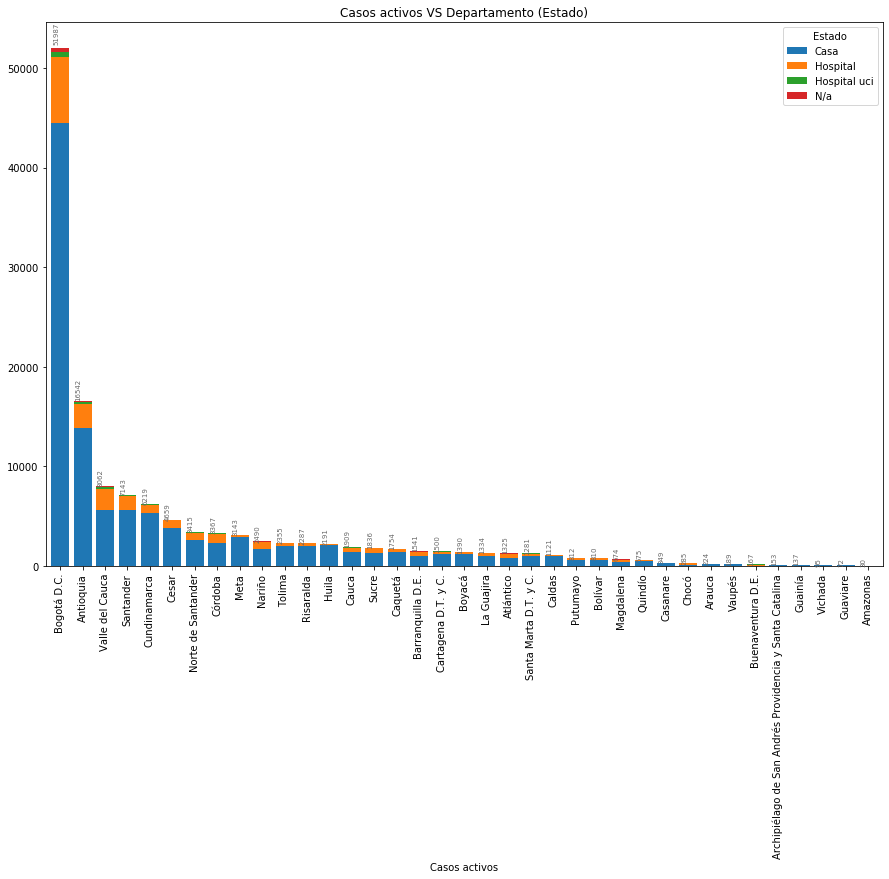

In [14]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos activos VS Departamento (Estado)'))
ax.set_xlabel('Casos activos')
div = len(li.columns)-1
numbers(div)

In [15]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Hospital  \
Departamento                                                            
Bogotá D.C.                                         44495.0    6578.0   
Antioquia                                           13835.0    2409.0   
Valle del Cauca                                      5597.0    2106.0   
Santander                                            5674.0    1380.0   
Cundinamarca                                         5335.0     826.0   
Cesar                                                3857.0     738.0   
Norte de Santander                                   2639.0     694.0   
Córdoba                                              2285.0     931.0   
Meta                                                 2902.0     213.0   
Nariño                                               1756.0     656.0   
Tolima                                               1976.0     325.0   
Risaralda                                            2013.0     253.0   
Huila                                                2072.0     104.0   
Cauca                                                1409.0     437.0   
Sucre                                                1264.0     529.0   
Caquetá                                              1421.0     308.0   
Barranquilla D.E.                                     985.0     415.0   
Cartagena D.T. y C.                                  1231.0     195.0   
Boyacá                                               1182.0     182.0   
La Guajira                                           1046.0     254.0   
Atlántico                                             839.0     341.0   
Santa Marta D.T. y C.                                 979.0     272.0   
Caldas                                                998.0     103.0   
Putumayo                                              579.0     222.0   
Bolívar                                               613.0     151.0   
Magdalena                                             434.0     186.0   
Quindío                                               522.0      50.0   
Casanare                                              277.0      64.0   
Chocó                                                 119.0     140.0   
Arauca                                                198.0      22.0   
Vaupés                                                179.0      10.0   
Buenaventura D.E.                                      51.0      92.0   
Archipiélago de San Andrés Providencia y Santa ...    141.0      11.0   
Guainía                                               135.0       2.0   
Vichada                                                94.0       1.0   
Guaviare                                               64.0       6.0   
Amazonas                                               21.0       5.0   

Estado                                              Hospital uci    N/a  \
Departamento                                                              
Bogotá D.C.                                                571.0  343.0   
Antioquia                                                  181.0  117.0   
Valle del Cauca                                            240.0  119.0   
Santander                                                   60.0   29.0   
Cundinamarca                                                26.0   32.0   
Cesar                                                       44.0   20.0   
Norte de Santander                                          61.0   21.0   
Córdoba                                                     54.0   97.0   
Meta                                                        11.0   17.0   
Nariño                                                      45.0   33.0   
Tolima                                                      23.0   31.0   
Risaralda                                                   11.0   10.0   
Huila                                                        1.0   14.0   
Cauca                      

### - Recuperados y Fallecidos VS Departamento

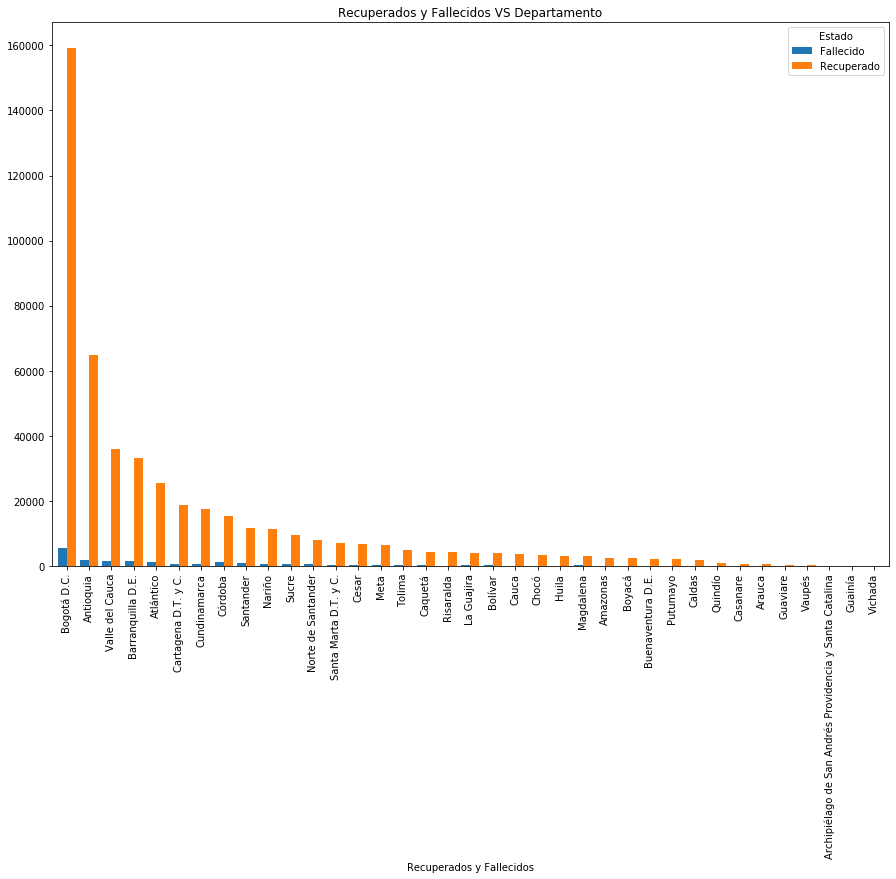

In [16]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, True, False, False, False, True]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=False, figsize=(15,10), title=('Recuperados y Fallecidos VS Departamento'))
ax.set_xlabel('Recuperados y Fallecidos')
div = len(li.columns)-1
#numbers(div)

In [17]:
li.sort_values('Total', ascending=False).iloc[:,:len(li.columns)-1]

Estado                                              Fallecido  Recuperado
Departamento                                                             
Bogotá D.C.                                            5593.0    159074.0
Antioquia                                              1784.0     64922.0
Valle del Cauca                                        1647.0     36003.0
Barranquilla D.E.                                      1620.0     33114.0
Atlántico                                              1297.0     25460.0
Cartagena D.T. y C.                                     525.0     18606.0
Cundinamarca                                            691.0     17474.0
Córdoba                                                1353.0     15339.0
Santander                                               821.0     11710.0
Nariño                                                  542.0     11414.0
Sucre                                                   503.0      9600.0
Norte de Santander                                      678.0      8075.0
Santa Marta D.T. y C.                                   357.0      7013.0
Cesar                                                   325.0      6813.0
Meta                                                    223.0      6399.0
Tolima                                                  193.0      5069.0
Caquetá                                                 207.0      4346.0
Risaralda                                               120.0      4228.0
La Guajira                                              238.0      3876.0
Bolívar                                                 191.0      3898.0
Cauca                                                   166.0      3574.0
Chocó                                                   138.0      3327.0
Huila                                                   149.0      3181.0
Magdalena                                               338.0      2986.0
Amazonas                                                110.0      2563.0
Boyacá                                                   81.0      2578.0
Buenaventura D.E.                                       158.0      2090.0
Putumayo                                                139.0      2088.0
Caldas                                                   61.0      1906.0
Quindío                                                  42.0       788.0
Casanare                                                 24.0       756.0
Arauca                                                   18.0       743.0
Guaviare                                                  4.0       221.0
Vaupés                                                    1.0       172.0
Archipiélago de San Andrés Providencia y Santa ...        3.0       117.0
Guainía                                                   5.0        22.0
Vichada                                                   3.0        23.0

* Fallecimientos relacionados al COVID-19.

### - Casos confirmados VS Departamento (Estado)

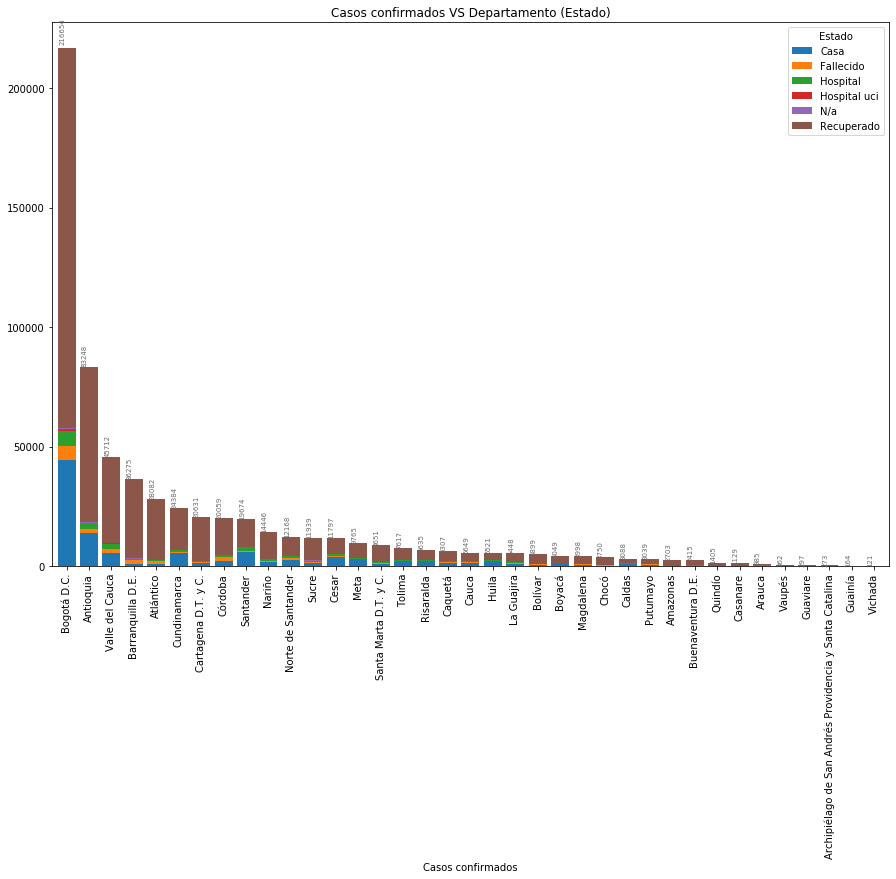

In [18]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [19]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         44495.0     5593.0   
Antioquia                                           13835.0     1784.0   
Valle del Cauca                                      5597.0     1647.0   
Barranquilla D.E.                                     985.0     1620.0   
Atlántico                                             839.0     1297.0   
Cundinamarca                                         5335.0      691.0   
Cartagena D.T. y C.                                  1231.0      525.0   
Córdoba                                              2285.0     1353.0   
Santander                                            5674.0      821.0   
Nariño                                               1756.0      542.0   
Norte de Santander                                   2639.0      678.0   
Sucre                                                1264.0      503.0   
Cesar                                                3857.0      325.0   
Meta                                                 2902.0      223.0   
Santa Marta D.T. y C.                                 979.0      357.0   
Tolima                                               1976.0      193.0   
Risaralda                                            2013.0      120.0   
Caquetá                                              1421.0      207.0   
Cauca                                                1409.0      166.0   
Huila                                                2072.0      149.0   
La Guajira                                           1046.0      238.0   
Bolívar                                               613.0      191.0   
Boyacá                                               1182.0       81.0   
Magdalena                                             434.0      338.0   
Chocó                                                 119.0      138.0   
Caldas                                                998.0       61.0   
Putumayo                                              579.0      139.0   
Amazonas                                               21.0      110.0   
Buenaventura D.E.                                      51.0      158.0   
Quindío                                               522.0       42.0   
Casanare                                              277.0       24.0   
Arauca                                                198.0       18.0   
Vaupés                                                179.0        1.0   
Guaviare                                               64.0        4.0   
Archipiélago de San Andrés Providencia y Santa ...    141.0        3.0   
Guainía                                               135.0        5.0   
Vichada                                                94.0        3.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           6578.0         571.0   
Antioquia                                             2409.0         181.0   
Valle del Cauca                                       2106.0         240.0   
Barranquilla D.E.                                      415.0          38.0   
Atlántico                                              341.0          53.0   
Cundinamarca                                           826.0          26.0   
Cartagena D.T. y C.                                    195.0          40.0   
Córdoba                                                931.0          54.0   
Santander                                             1380.0          60.0   
Nariño                                                 656.0          45.0   
Norte de Santander                                     694.0          61.0   
Sucre                                                  529.0          20.0   
Cesar                

### - Casos confirmados VS Departamento (Sexo)

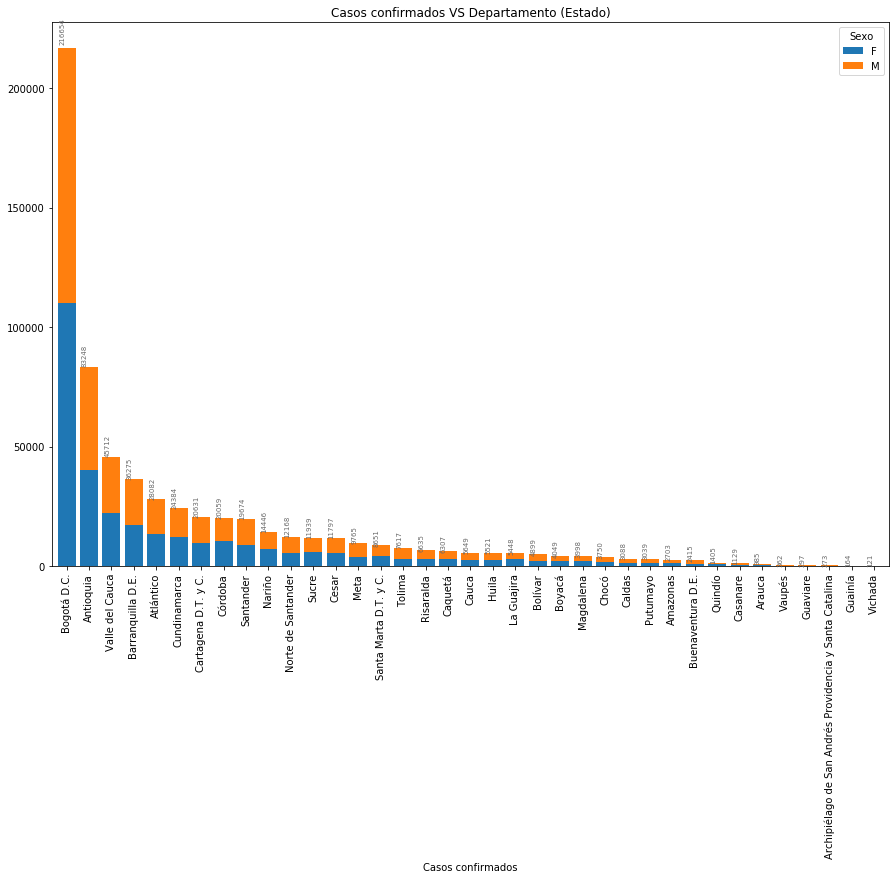

In [20]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [21]:
li.sort_values('Total', ascending=False)

Sexo                                                     F       M   Total
Departamento                                                              
Bogotá D.C.                                         110157  106497  216654
Antioquia                                            40187   43061   83248
Valle del Cauca                                      22188   23524   45712
Barranquilla D.E.                                    17111   19164   36275
Atlántico                                            13302   14780   28082
Cundinamarca                                         12358   12026   24384
Cartagena D.T. y C.                                   9529   11102   20631
Córdoba                                              10314    9745   20059
Santander                                             8660   11014   19674
Nariño                                                6964    7482   14446
Norte de Santander                                    5654    6514   12168
Sucre                                                 5826    6113   11939
Cesar                                                 5599    6198   11797
Meta                                                  3756    6009    9765
Santa Marta D.T. y C.                                 4336    4315    8651
Tolima                                                2979    4638    7617
Risaralda                                             3159    3476    6635
Caquetá                                               3118    3189    6307
Cauca                                                 2711    2938    5649
Huila                                                 2731    2790    5521
La Guajira                                            2757    2691    5448
Bolívar                                               2282    2617    4899
Boyacá                                                1906    2143    4049
Magdalena                                             2026    1972    3998
Chocó                                                 1777    1973    3750
Caldas                                                1441    1647    3088
Putumayo                                              1408    1631    3039
Amazonas                                              1167    1536    2703
Buenaventura D.E.                                      901    1514    2415
Quindío                                                693     712    1405
Casanare                                               466     663    1129
Arauca                                                 326     659     985
Vaupés                                                 152     210     362
Guaviare                                                61     236     297
Archipiélago de San Andrés Providencia y Santa ...     147     126     273
Guainía                                                 67      97     164
Vichada                                                 33      88     121

### - Mapa de influencia COVID-19 (Colombia)

In [22]:
global_map = go.Figure(data = go.Choropleth(
    z = data['País de procedencia'].value_counts().sort_index().tolist(),
    locations = sorted(data['País de procedencia'].unique().tolist()),
    locationmode = 'country names',
    colorscale = 'greens',
    colorbar_title = "Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

global_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

global_map.show()

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

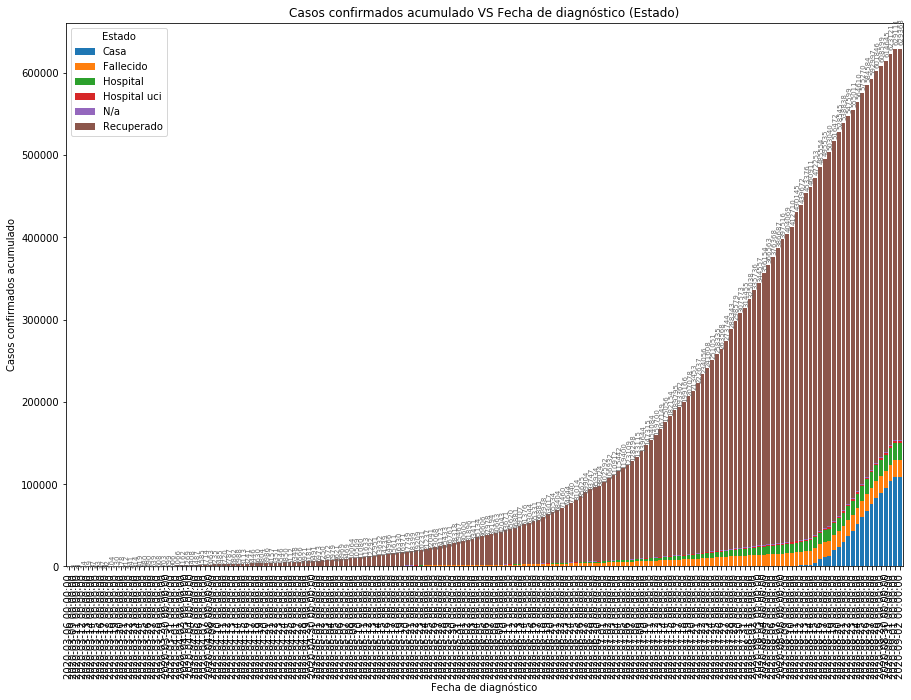

In [23]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [24]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Estado                    Casa  Fallecido  Hospital  Hospital uci     N/a  \
Fecha de diagnóstico                                                        
2020-09-02            109084.0    20142.0   21153.0        1665.0  1295.0   
2020-09-01            108844.0    20142.0   21141.0        1665.0  1295.0   
2020-08-31            103164.0    20138.0   20841.0        1665.0  1295.0   
2020-08-30             95153.0    20092.0   20429.0        1665.0  1290.0   
2020-08-29             89459.0    20048.0   20129.0        1665.0  1287.0   
2020-08-28             83196.0    19961.0   19811.0        1665.0  1282.0   
2020-08-27             75225.0    19856.0   19269.0        1665.0  1280.0   
2020-08-26             67637.0    19725.0   18768.0        1665.0  1272.0   
2020-08-25             59620.0    19544.0   18239.0        1665.0  1262.0   
2020-08-24             50890.0    19392.0   17771.0        1665.0  1254.0   
2020-08-23             43255.0    19202.0   17263.0        1665.0  1240.0   
2020-08-22             36808.0    19084.0   16913.0        1665.0  1237.0   
2020-08-21             29863.0    18889.0   16469.0        1665.0  1229.0   
2020-08-20             23970.0    18674.0   15923.0        1664.0  1211.0   
2020-08-19             19210.0    18323.0   15229.0        1608.0  1197.0   
2020-08-18             13045.0    18044.0   14663.0        1566.0  1181.0   
2020-08-17             11523.0    17811.0   14315.0        1556.0  1160.0   
2020-08-16              9107.0    17639.0   14003.0        1540.0  1151.0   
2020-08-15              4511.0    17357.0   13561.0        1517.0  1142.0   
2020-08-14              1734.0    17071.0   13127.0        1499.0  1133.0   
2020-08-13              1278.0    16835.0   12838.0        1489.0  1125.0   
2020-08-12               973.0    16527.0   12361.0        1468.0  1109.0   
2020-08-11               689.0    16176.0   11951.0        1446.0  1097.0   
2020-08-10               480.0    15769.0   11334.0        1401.0  1078.0   
2020-08-09               332.0    15541.0   11013.0        1384.0  1060.0   
2020-08-08               166.0    15322.0   10729.0        1366.0  1053.0   
2020-08-07               138.0    15005.0   10455.0        1337.0  1037.0   
2020-08-06               126.0    14718.0   10143.0        1299.0  1017.0   
2020-08-05               103.0    14431.0    9889.0        1259.0   996.0   
2020-08-04                89.0    14137.0    9572.0        1220.0   973.0   
2020-08-03                82.0    13811.0    9269.0        1182.0   958.0   
2020-08-02                72.0    13470.0    8910.0        1158.0   937.0   
2020-08-01                67.0    13105.0    8534.0        1122.0   923.0   
2020-07-31                63.0    12759.0    8091.0        1090.0   903.0   
2020-07-30                59.0    12517.0    7851.0        1072.0   887.0   
2020-07-29                54.0    12221.0    7585.0        1031.0   866.0   
2020-07-28                38.0    11921.0    7280.0         989.0   843.0   
2020-07-27                35.0    11362.0    6800.0         939.0   803.0   
2020-07-26                32.0    11034.0    6519.0         907.0   779.0   
2020-07-25                32.0    10788.0    6336.0         884.0   766.0   
2020-07-24                31.0    10483.0    6046.0         850.0   748.0   
2020-07-23                31.0    10179.0    5776.0         822.0   727.0   
2020-07-22                30.0     9802.0    5446.0         784.0   698.0   
2020-07-21                26.0     9355.0    5041.0         736.0   671.0   
2020-07-20                23.0     9005.0    4790.0         693.0   656.0   
2020-07-19                23.0     8731.0    4515.0         665.0   644.0   
2020-07-18                20.0     8448.0    4305.0         643.0   627.0   
2020-07-17                17.0     8205.0    4138.0         616.0   605.0   
2020-07-16                14.0     8028.0    4043.0         602.0   596.0   
2020-07-15                12.0     7741.0    3793.0         566.0   576.0

### - Casos confirmados VS Fecha de diagnóstico (Estado)

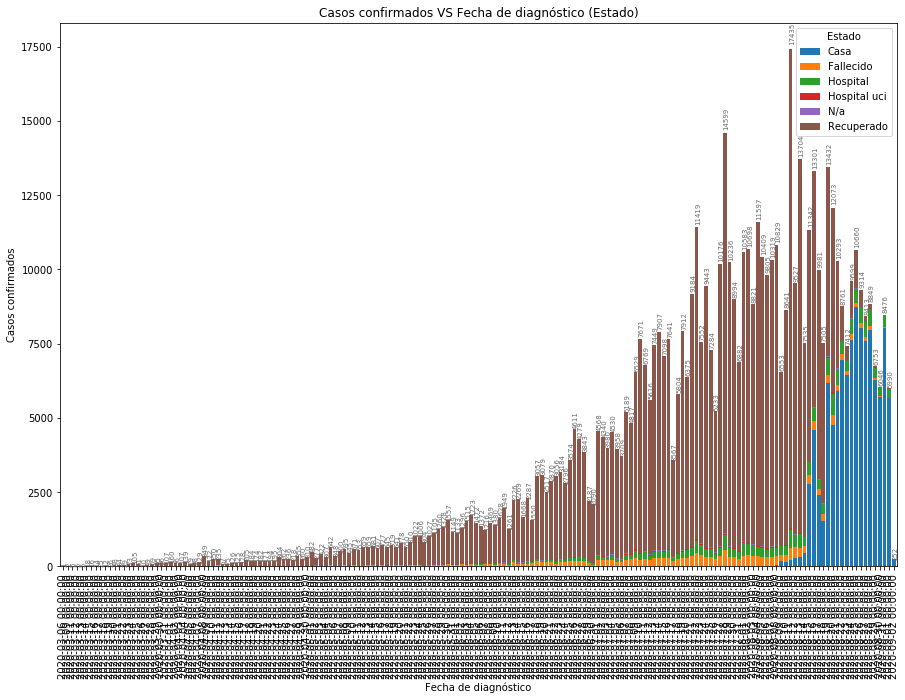

In [25]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [26]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)[::-1]

Estado                  Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                    
2020-09-02             240.0        0.0      12.0           0.0   0.0   
2020-09-01            5680.0        4.0     300.0           0.0   0.0   
2020-08-31            8011.0       46.0     412.0           0.0   5.0   
2020-08-30            5694.0       44.0     300.0           0.0   3.0   
2020-08-29            6263.0       87.0     318.0           0.0   5.0   
2020-08-28            7971.0      105.0     542.0           0.0   2.0   
2020-08-27            7588.0      131.0     501.0           0.0   8.0   
2020-08-26            8017.0      181.0     529.0           0.0  10.0   
2020-08-25            8730.0      152.0     468.0           0.0   8.0   
2020-08-24            7635.0      190.0     508.0           0.0  14.0   
2020-08-23            6447.0      118.0     350.0           0.0   3.0   
2020-08-22            6945.0      195.0     444.0           0.0   8.0   
2020-08-21            5893.0      215.0     546.0           1.0  18.0   
2020-08-20            4760.0      351.0     694.0          56.0  14.0   
2020-08-19            6165.0      279.0     566.0          42.0  16.0   
2020-08-18            1522.0      233.0     348.0          10.0  21.0   
2020-08-17            2416.0      172.0     312.0          16.0   9.0   
2020-08-16            4596.0      282.0     442.0          23.0   9.0   
2020-08-15            2777.0      286.0     434.0          18.0   9.0   
2020-08-14             456.0      236.0     289.0          10.0   8.0   
2020-08-13             305.0      308.0     477.0          21.0  16.0   
2020-08-12             284.0      351.0     410.0          22.0  12.0   
2020-08-11             209.0      407.0     617.0          45.0  19.0   
2020-08-10             148.0      228.0     321.0          17.0  18.0   
2020-08-09             166.0      219.0     284.0          18.0   7.0   
2020-08-08              28.0      317.0     274.0          29.0  16.0   
2020-08-07              12.0      287.0     312.0          38.0  20.0   
2020-08-06              23.0      287.0     254.0          40.0  21.0   
2020-08-05              14.0      294.0     317.0          39.0  23.0   
2020-08-04               7.0      326.0     303.0          38.0  15.0   
2020-08-03              10.0      341.0     359.0          24.0  21.0   
2020-08-02               5.0      365.0     376.0          36.0  14.0   
2020-08-01               4.0      346.0     443.0          32.0  20.0   
2020-07-31               4.0      242.0     240.0          18.0  16.0   
2020-07-30               5.0      296.0     266.0          41.0  21.0   
2020-07-29              16.0      300.0     305.0          42.0  23.0   
2020-07-28               3.0      559.0     480.0          50.0  40.0   
2020-07-27               3.0      328.0     281.0          32.0  24.0   
2020-07-26               0.0      246.0     183.0          23.0  13.0   
2020-07-25               1.0      305.0     290.0          34.0  18.0   
2020-07-24               0.0      304.0     270.0          28.0  21.0   
2020-07-23               1.0      377.0     330.0          38.0  29.0   
2020-07-22               4.0      447.0     405.0          48.0  27.0   
2020-07-21               3.0      350.0     251.0          43.0  15.0   
2020-07-20               0.0      274.0     275.0          28.0  12.0   
2020-07-19               3.0      283.0     210.0          22.0  17.0   
2020-07-18               3.0      243.0     167.0          27.0  22.0   
2020-07-17               3.0      177.0      95.0          14.0   9.0   
2020-07-16               2.0      287.0     250.0          36.0  20.0   
2020-07-15               0.0      296.0     201.0          30.0  11.0   
2020-07-14               0.0      286.0     214.0          28.0  26.0   
2020-07-13               1.0      269.0     228.0          30.0  21.0   
2020-07-12               1.0      213.0     149.0         

### - Casos confirmados VS Clasificación de edad (Estado)

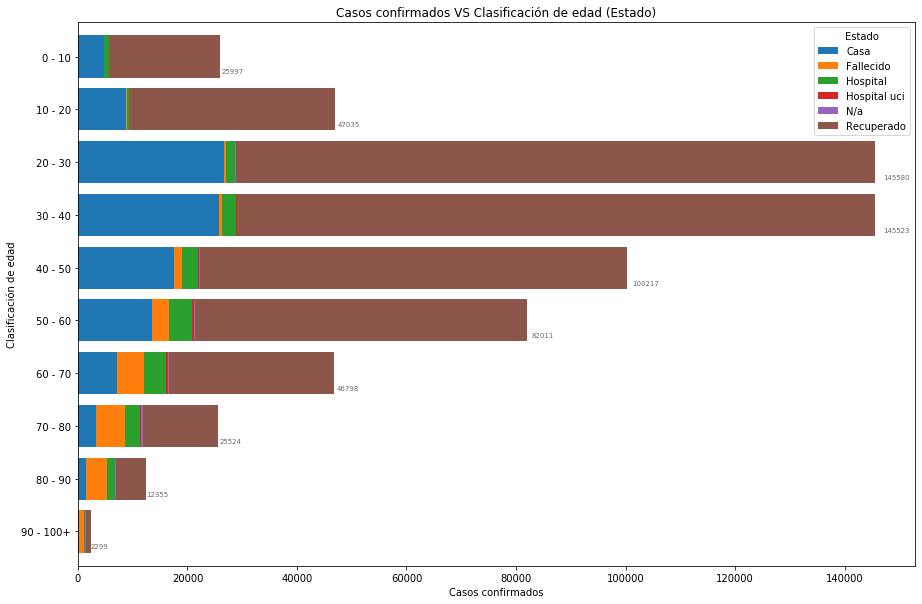

In [27]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Estado)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [28]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  4741         35       908            38   32   
10 - 20                 8837         33       438            26   24   
20 - 30                26715        262      1702            72   57   
30 - 40                25721        663      2516           174   49   
40 - 50                17451       1473      2991           261  100   
50 - 60                13521       3056      4278           428  158   
60 - 70                 7089       4903      4046           401  271   
70 - 80                 3353       5209      2806           225  312   
80 - 90                 1507       3845      1345            46  254   
90 - 100+                282        869       181             5   62   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      20243  
10 - 20                     37677  
20 - 30                    116772  
30 - 40                    116400  
40 - 50                     77941  
50 - 60                     60570  
60 - 70                     30088  
70 - 80                     13619  
80 - 90                      5358  
90 - 100+                     900

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

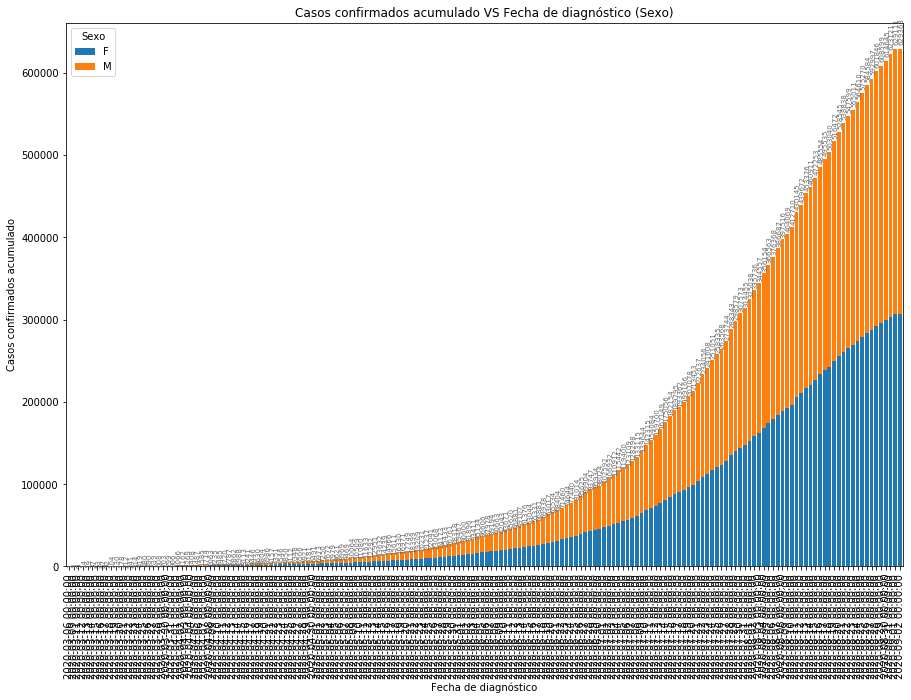

In [29]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [30]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Sexo                         F         M
Fecha de diagnóstico                    
2020-09-02            306352.0  323011.0
2020-09-01            306213.0  322898.0
2020-08-31            303294.0  319827.0
2020-08-30            298816.0  315829.0
2020-08-29            295734.0  312865.0
2020-08-28            292311.0  309535.0
2020-08-27            287864.0  305133.0
2020-08-26            283641.0  300943.0
2020-08-25            278882.0  296388.0
2020-08-24            273527.0  291083.0
2020-08-23            268729.0  286282.0
2020-08-22            264970.0  282629.0
2020-08-21            260835.0  278003.0
2020-08-20            255650.0  272895.0
2020-08-19            249568.0  266904.0
2020-08-18            242593.0  260447.0
2020-08-17            238975.0  256560.0
2020-08-16            233699.0  251855.0
2020-08-15            226746.0  245507.0
2020-08-14            220981.0  239930.0
2020-08-13            217123.0  236253.0
2020-08-12            210262.0  229410.0
2020-08-11            205540.0  224605.0
2020-08-10            196507.0  216203.0
2020-08-09            192169.0  211900.0
2020-08-08            188791.0  208725.0
2020-08-07            183520.0  203167.0
2020-08-06            178479.0  197889.0
2020-08-05            173625.0  192938.0
2020-08-04            168413.0  187741.0
2020-08-03            162600.0  181957.0
2020-08-02            158332.0  177404.0
2020-08-01            152862.0  172176.0
2020-07-31            147742.0  166713.0
2020-07-30            144293.0  163280.0
2020-07-29            139920.0  158659.0
2020-07-28            134839.0  153504.0
2020-07-27            127729.0  146015.0
2020-07-26            122853.0  140715.0
2020-07-25            120455.0  137880.0
2020-07-24            116768.0  134283.0
2020-07-23            112402.0  129206.0
2020-07-22            108833.0  125223.0
2020-07-21            103669.0  118968.0
2020-07-20             99365.0  114088.0
2020-07-19             96389.0  110689.0
2020-07-18             92600.0  106566.0
2020-07-17             89819.0  103543.0
2020-07-16             88062.0  101733.0
2020-07-15             84313.0   97841.0
2020-07-14             80940.0   94116.0
2020-07-13             77344.0   89805.0
2020-07-12             73773.0   85927.0
2020-07-11             71099.0   82985.0
2020-07-10             67885.0   79430.0
2020-07-09             64381.0   75263.0
2020-07-08             61418.0   71697.0
2020-07-07             59108.0   69190.0
2020-07-06             56699.0   66410.0
2020-07-05             54946.0   64454.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

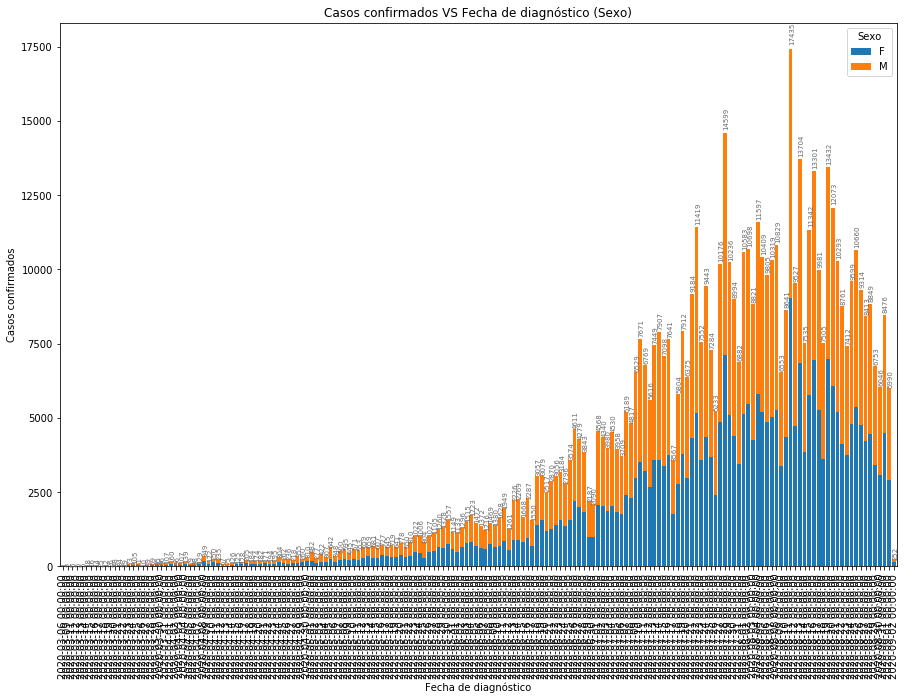

In [31]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [32]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)[::-1]

Sexo                       F       M
Fecha de diagnóstico                
2020-09-02             139.0   113.0
2020-09-01            2919.0  3071.0
2020-08-31            4478.0  3998.0
2020-08-30            3082.0  2964.0
2020-08-29            3423.0  3330.0
2020-08-28            4447.0  4402.0
2020-08-27            4223.0  4190.0
2020-08-26            4759.0  4555.0
2020-08-25            5355.0  5305.0
2020-08-24            4798.0  4801.0
2020-08-23            3759.0  3653.0
2020-08-22            4135.0  4626.0
2020-08-21            5185.0  5108.0
2020-08-20            6082.0  5991.0
2020-08-19            6975.0  6457.0
2020-08-18            3618.0  3887.0
2020-08-17            5276.0  4705.0
2020-08-16            6953.0  6348.0
2020-08-15            5765.0  5577.0
2020-08-14            3858.0  3677.0
2020-08-13            6861.0  6843.0
2020-08-12            4722.0  4805.0
2020-08-11            9033.0  8402.0
2020-08-10            4338.0  4303.0
2020-08-09            3378.0  3175.0
2020-08-08            5271.0  5558.0
2020-08-07            5041.0  5278.0
2020-08-06            4854.0  4951.0
2020-08-05            5212.0  5197.0
2020-08-04            5813.0  5784.0
2020-08-03            4268.0  4553.0
2020-08-02            5470.0  5228.0
2020-08-01            5120.0  5463.0
2020-07-31            3449.0  3433.0
2020-07-30            4373.0  4621.0
2020-07-29            5081.0  5155.0
2020-07-28            7110.0  7489.0
2020-07-27            4876.0  5300.0
2020-07-26            2398.0  2835.0
2020-07-25            3687.0  3597.0
2020-07-24            4366.0  5077.0
2020-07-23            3569.0  3983.0
2020-07-22            5164.0  6255.0
2020-07-21            4304.0  4880.0
2020-07-20            2976.0  3399.0
2020-07-19            3789.0  4123.0
2020-07-18            2781.0  3023.0
2020-07-17            1757.0  1810.0
2020-07-16            3749.0  3892.0
2020-07-15            3373.0  3725.0
2020-07-14            3596.0  4311.0
2020-07-13            3571.0  3878.0
2020-07-12            2674.0  2942.0
2020-07-11            3214.0  3555.0
2020-07-10            3504.0  4167.0
2020-07-09            2963.0  3566.0
2020-07-08            2310.0  2507.0
2020-07-07            2409.0  2780.0
2020-07-06            1753.0  1956.0
2020-07-05            1834.0  2124.0

### - Casos confirmados VS Clasificación de edad (Sexo)

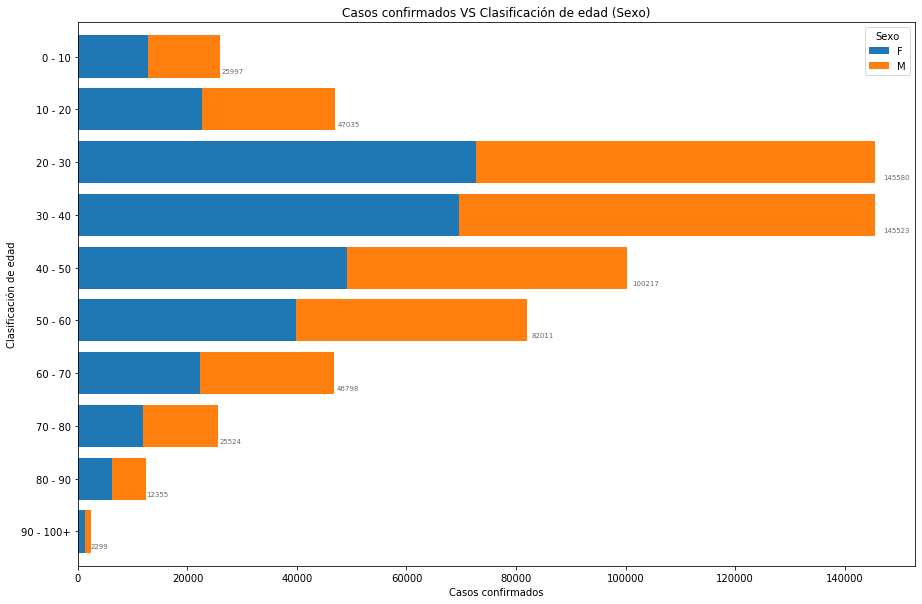

In [33]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [34]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F      M
Clasificación de edad              
0 - 10                 12708  13289
10 - 20                22648  24387
20 - 30                72681  72899
30 - 40                69535  75988
40 - 50                49115  51102
50 - 60                39777  42234
60 - 70                22270  24528
70 - 80                11910  13614
80 - 90                 6303   6052
90 - 100+               1302    997

### - Casos confirmados VS Estado (Sexo)

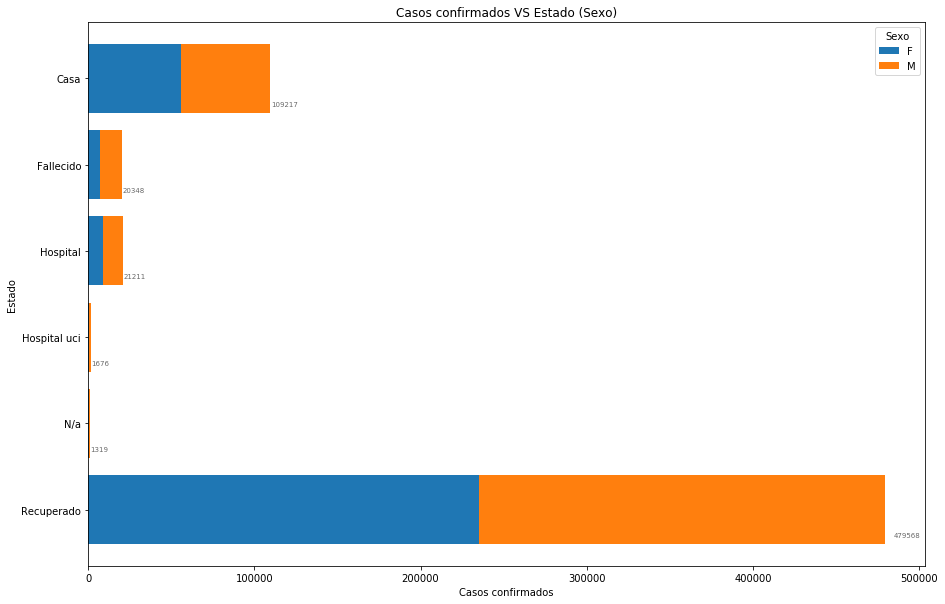

In [35]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [36]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           55871   53346
Fallecido       7299   13049
Hospital        9013   12198
Hospital uci     579    1097
N/a              569     750
Recuperado    234918  244650

### - Casos confirmados VS Tipo de contagio (Sexo)

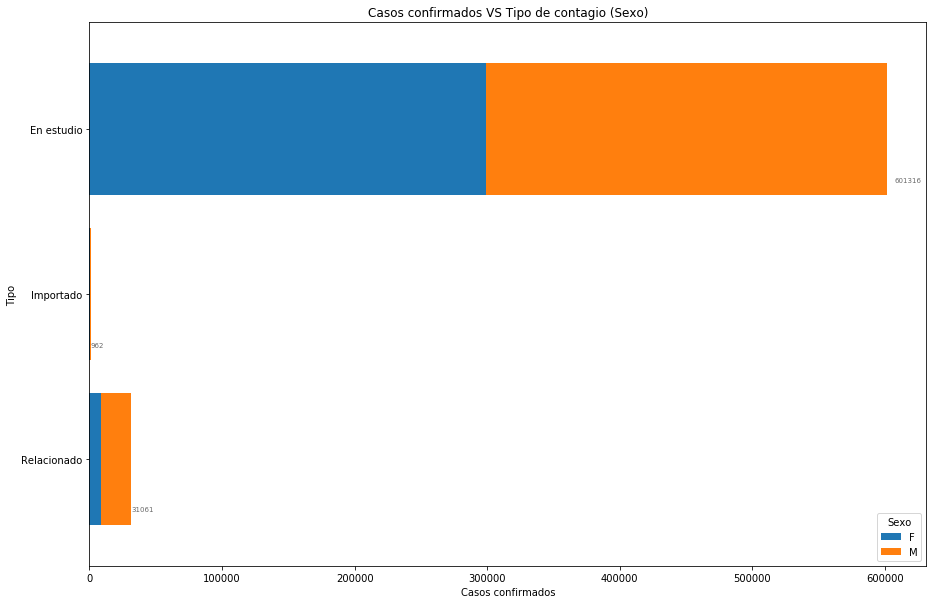

In [37]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo de contagio (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [38]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   299053  302263
Importado       455     507
Relacionado    8741   22320

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

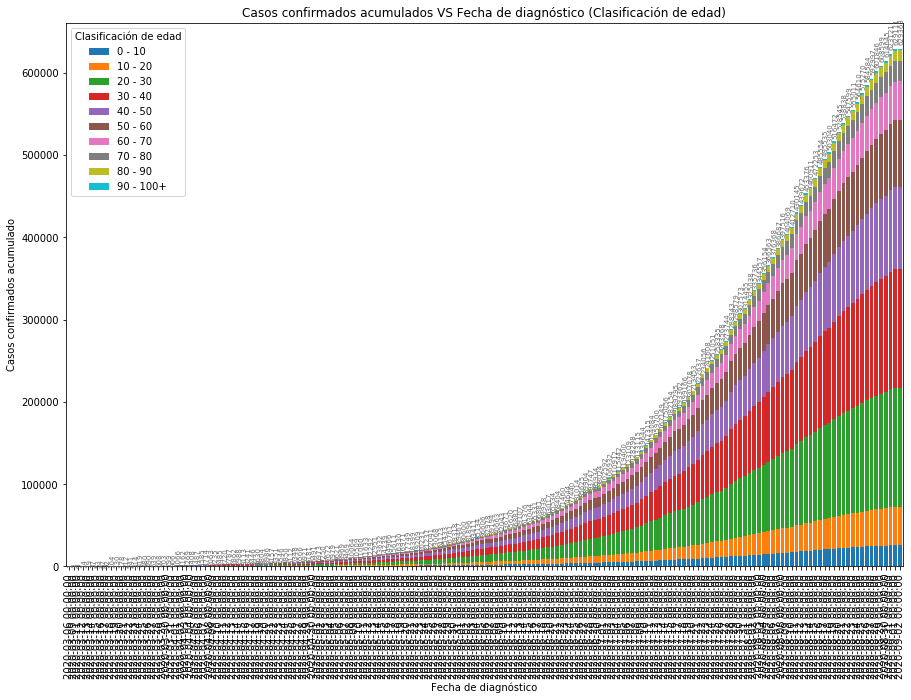

In [39]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [40]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-09-02              25858    46749   144616   144567    99629    81527   
2020-09-01              25849    46734   144563   144512    99592    81493   
2020-08-31              25617    46288   143197   143164    98664    80721   
2020-08-30              25227    45631   141188   141298    97317    79675   
2020-08-29              24990    45168   139761   139933    96375    78899   
2020-08-28              24743    44650   138180   138455    95336    77970   
2020-08-27              24425    44052   136192   136376    93949    76795   
2020-08-26              24089    43437   134243   134456    92605    75730   
2020-08-25              23744    42731   132244   132339    91102    74564   
2020-08-24              23357    42038   129825   129839    89376    73138   
2020-08-23              22995    41331   127592   127683    87873    71897   
2020-08-22              22687    40732   125824   125957    86776    70921   
2020-08-21              22367    40073   123804   123874    85457    69813   
2020-08-20              21947    39329   121351   121538    83830    68468   
2020-08-19              21462    38473   118699   118828    81913    66857   
2020-08-18              20834    37491   115680   115821    79707    65159   
2020-08-17              20581    36977   114009   114127    78511    64133   
2020-08-16              20067    36217   111797   112028    76918    62795   
2020-08-15              19449    35081   108837   109130    74801    61046   
2020-08-14              18949    34242   106224   106624    73014    59522   
2020-08-13              18696    33699   104498   104947    71798    58462   
2020-08-12              18073    32635   101397   101844    69609    56657   
2020-08-11              17725    32000    99312    99637    68094    55394   
2020-08-10              16931    30749    95200    95602    65259    53145   
2020-08-09              16600    30068    93249    93595    63905    52029   
2020-08-08              16356    29641    91741    92166    62823    51145   
2020-08-07              15940    28857    89303    89525    61117    49724   
2020-08-06              15526    28086    86943    87091    59477    48388   
2020-08-05              15077    27341    84764    84850    57907    47114   
2020-08-04              14650    26615    82380    82438    56219    45749   
2020-08-03              14161    25797    79722    79727    54316    44165   
2020-08-02              13837    25188    77723    77676    52969    42947   
2020-08-01              13394    24468    75312    75281    51162    41446   
2020-07-31              12980    23613    72757    72772    49541    40102   
2020-07-30              12707    23155    71227    71135    48366    39252   
2020-07-29              12363    22442    69045    69003    47039    38076   
2020-07-28              11981    21696    66619    66528    45353    36831   
2020-07-27              11352    20560    63294    63240    43036    34898   
2020-07-26              10966    19838    60906    60855    41366    33685   
2020-07-25              10756    19513    59717    59628    40552    33004   
2020-07-24              10472    19029    58080    57924    39386    32014   
2020-07-23              10151    18308    55875    55635    37909    30780   
2020-07-22               9874    17792    54191    53887    36708    29790   
2020-07-21               9468    16944    51469    51298    34922    28245   
2020-07-20               9108    16317    49304    49117    33438    27093   
2020-07-19               8830    15857    47949    47657    32368    26264   
2020-07-18               8517    15197    46115    45801    31058    25282   
2020-07-17               8295    14855    44821    44385    30101    24530   
2020-07-16               8172    14636    44019    43524    29554    24076   
2020-07-15            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

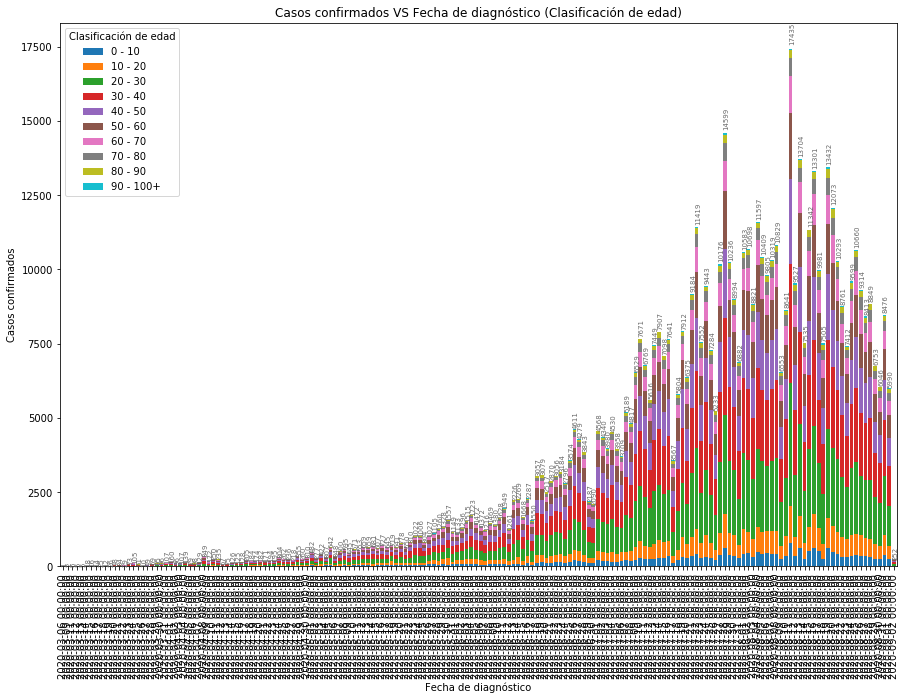

In [41]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [42]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-09-02                  9       15       53       55       37       34   
2020-09-01                232      446     1366     1348      928      772   
2020-08-31                390      657     2009     1866     1347     1046   
2020-08-30                237      463     1427     1365      942      776   
2020-08-29                247      518     1581     1478     1039      929   
2020-08-28                318      598     1988     2079     1387     1175   
2020-08-27                336      615     1949     1920     1344     1065   
2020-08-26                345      706     1999     2117     1503     1166   
2020-08-25                387      693     2419     2500     1726     1426   
2020-08-24                362      707     2233     2156     1503     1241   
2020-08-23                308      599     1768     1726     1097      976   
2020-08-22                320      659     2020     2083     1319     1108   
2020-08-21                420      744     2453     2336     1627     1345   
2020-08-20                485      856     2652     2710     1917     1611   
2020-08-19                628      982     3019     3007     2206     1698   
2020-08-18                253      514     1671     1694     1196     1026   
2020-08-17                514      760     2212     2099     1593     1338   
2020-08-16                618     1136     2960     2898     2117     1749   
2020-08-15                500      839     2613     2506     1787     1524   
2020-08-14                253      543     1726     1677     1216     1060   
2020-08-13                623     1064     3101     3103     2189     1805   
2020-08-12                348      635     2085     2207     1515     1263   
2020-08-11                794     1251     4112     4035     2835     2249   
2020-08-10                331      681     1951     2007     1354     1116   
2020-08-09                244      427     1508     1429     1082      884   
2020-08-08                416      784     2438     2641     1706     1421   
2020-08-07                414      771     2360     2434     1640     1336   
2020-08-06                449      745     2179     2241     1570     1274   
2020-08-05                427      726     2384     2412     1688     1365   
2020-08-04                489      818     2658     2711     1903     1584   
2020-08-03                324      609     1999     2051     1347     1218   
2020-08-02                443      720     2411     2395     1807     1501   
2020-08-01                414      855     2555     2509     1621     1344   
2020-07-31                273      458     1530     1637     1175      850   
2020-07-30                344      713     2182     2132     1327     1176   
2020-07-29                382      746     2426     2475     1686     1245   
2020-07-28                629     1136     3325     3288     2317     1933   
2020-07-27                386      722     2388     2385     1670     1213   
2020-07-26                210      325     1189     1227      814      681   
2020-07-25                284      484     1637     1704     1166      990   
2020-07-24                321      721     2205     2289     1477     1234   
2020-07-23                277      516     1684     1748     1201      990   
2020-07-22                406      848     2722     2589     1786     1545   
2020-07-21                360      627     2165     2181     1484     1152   
2020-07-20                278      460     1355     1460     1070      829   
2020-07-19                313      660     1834     1856     1310      982   
2020-07-18                222      342     1294     1416      957      752   
2020-07-17                123      219      802      861      547      454   
2020-07-16                342      511     1713     1813     1253     1023   
2020-07-15            

### - Casos confirmados VS Estado (Clasificación de edad)

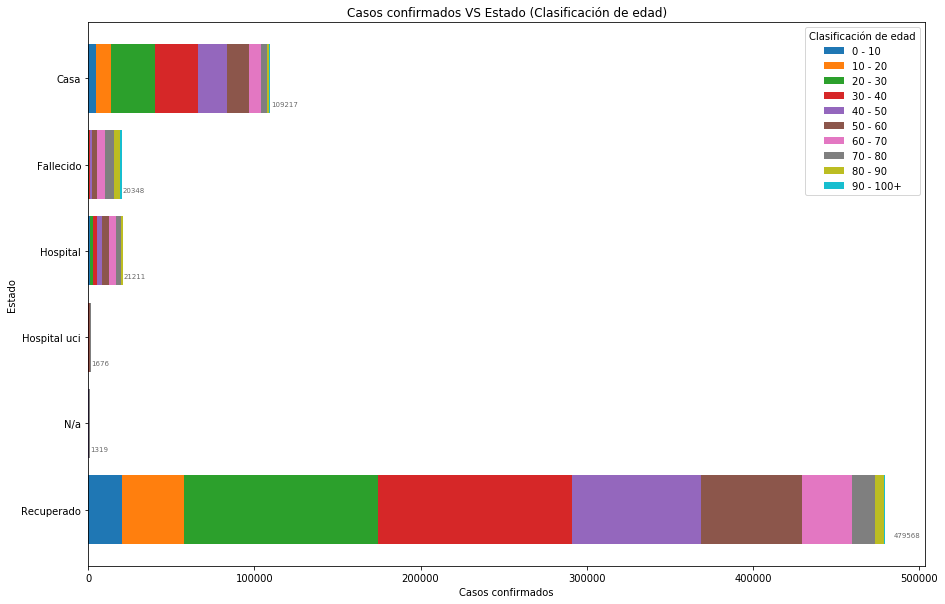

In [43]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [44]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     4741     8837    26715    25721    17451    13521   
Fallecido                  35       33      262      663     1473     3056   
Hospital                  908      438     1702     2516     2991     4278   
Hospital uci               38       26       72      174      261      428   
N/a                        32       24       57       49      100      158   
Recuperado              20243    37677   116772   116400    77941    60570   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      7089     3353     1507        282  
Fallecido                 4903     5209     3845        869  
Hospital                  4046     2806     1345        181  
Hospital uci               401      225       46          5  
N/a                        271      312      254         62  
Recuperado               30088    13619     5358        900

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

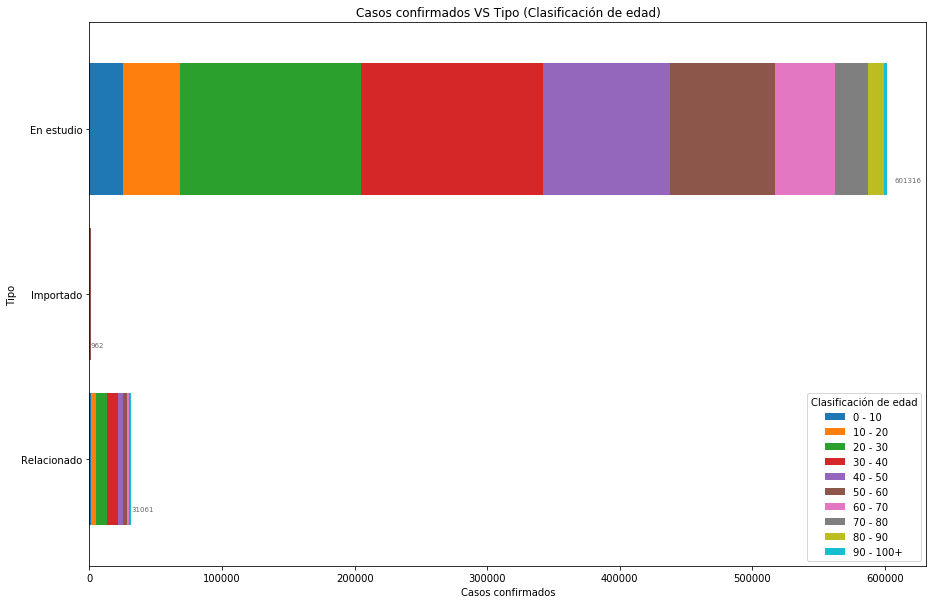

In [45]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [46]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              24979    43172   136648   137313    96114    79162   
Importado                   5       37      239      222      171      144   
Relacionado              1013     3826     8693     7988     3932     2705   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               45263    24745    11778       2142  
Importado                   97       36       10          1  
Relacionado               1438      743      567        156

## #StayHome 🏠 #QuédateEnCasa
## #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>